## 测量因子

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from Utility.factorFactory import FactorFactory
from Utility.Util import evaluate_time_series_ic
import matplotlib.pyplot as plt

### （1）预处理数据：

In [3]:
df = pd.read_csv ('df_minute.csv')
df.shape

(1920, 16)

In [4]:
df.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'dollar_volume',
       'vwap', 'tick_count', 'trade_size_mean', 'trade_size_std',
       'zero_return_count', 'price_direction_ratio', 'large_trade_count',
       'large_trade_ratio', 'large_trade_volume_ratio'],
      dtype='object')

In [5]:
finfact = FactorFactory(df, target_cols=['open', 'high', 'low', 'close', 'volume'])
df = finfact.generate_factors (layers=3, include_only_bounded_factors=True)
df.shape

🔄 Layer 3 cross: 100%|██████████| 30400/30400 [00:00<00:00, 70487.40it/s]


(1920, 29736)

In [8]:
df.columns.tolist()

['timestamp',
 'rsi_6_open',
 'rsi_6_high',
 'rsi_6_low',
 'rsi_6_close',
 'rsi_6_volume',
 'rsi_10_open',
 'rsi_10_high',
 'rsi_10_low',
 'rsi_10_close',
 'rsi_10_volume',
 'rsi_14_open',
 'rsi_14_high',
 'rsi_14_low',
 'rsi_14_close',
 'rsi_14_volume',
 'bb_pband_10_1.5',
 'bb_pband_10_2.0',
 'bb_pband_20_1.5',
 'bb_pband_20_2.0',
 'bb_pband_20_2.0_mul_rsi_14_close',
 'bb_pband_20_2.0_minus_rsi_14_low',
 'bb_pband_10_2.0_mul_rsi_10_close',
 'rsi_10_volume_minus_rsi_14_close',
 'rsi_10_open_minus_rsi_6_volume',
 'rsi_6_high_mul_rsi_6_open',
 'bb_pband_20_2.0_mul_rsi_14_low',
 'bb_pband_10_2.0_minus_rsi_10_low',
 'rsi_10_volume_mul_rsi_14_close',
 'rsi_10_open_mul_rsi_6_volume',
 'rsi_6_open_minus_bb_pband_20_2.0',
 'bb_pband_20_2.0_minus_rsi_14_high',
 'bb_pband_10_2.0_mul_rsi_10_low',
 'rsi_10_volume_minus_rsi_14_low',
 'rsi_10_open_minus_rsi_6_close',
 'bb_pband_20_2.0_mul_rsi_14_high',
 'bb_pband_10_2.0_minus_rsi_10_high',
 'rsi_10_volume_mul_rsi_14_low',
 'rsi_10_open_mul_rsi_6_cl

In [9]:
# 去掉 null
df = df.dropna()

# 计算每列的缺失值数量
null_counts = df.isnull().sum()
# 只保留那些缺失值数 > 0 的列
null_counts = null_counts[null_counts > 0]
print(null_counts)
df.shape, df.columns

Series([], dtype: int64)


((1901, 29736),
 Index(['timestamp', 'rsi_6_open', 'rsi_6_high', 'rsi_6_low', 'rsi_6_close',
        'rsi_6_volume', 'rsi_10_open', 'rsi_10_high', 'rsi_10_low',
        'rsi_10_close',
        ...
        'rsi_14_close_mul_rsi_10_volume_minus_rsi_10_volume',
        'rsi_14_open_mul_rsi_14_high_mul_rsi_14_open',
        'rsi_14_close_mul_rsi_10_volume_mul_rsi_10_volume',
        'rsi_14_open_mul_rsi_14_high_minus_rsi_10_volume',
        'rsi_14_close_mul_rsi_10_volume_minus_rsi_10_close',
        'rsi_14_open_mul_rsi_14_high_mul_rsi_10_volume',
        'rsi_14_close_mul_rsi_10_volume_mul_rsi_10_close',
        'rsi_14_open_mul_rsi_14_high_minus_rsi_10_close',
        'rsi_14_close_mul_rsi_10_volume_minus_rsi_10_low',
        'rsi_14_open_mul_rsi_14_high_mul_rsi_10_close'],
       dtype='object', length=29736))

### （3）评测因子：

#### IC分析

In [10]:
results = evaluate_time_series_ic(
    df=df,
    factors=df.columns.tolist(),
    target_col='close',
    forward=5,        # 往后 5 个 timestamp
    date_col='timestamp',
    window=100,
    n_jobs=12
)
results

KeyError: 'close'

In [10]:
# 选择出优质因子
results[results['ic_global'].abs () > 0.02]

,ic_global,ic_sw_mean,ic_sw_std,ir_sw
factor,,,,
rsi_6_close,-0.021919,-0.110101,0.175971,-0.625677
bb_pband_10_1.5,-0.022983,-0.085459,0.169866,-0.503098
bb_pband_10_2.0,-0.022983,-0.085459,0.169866,-0.503098
bb_pband_10_2.5,-0.022983,-0.085459,0.169866,-0.503098
rsi_cross_rsi_6_close_mul_rsi_10_close,-0.020968,-0.120809,0.178361,-0.677330
rsi_cross_rsi_6_close_minus_rsi_10_close,-0.020661,-0.042576,0.172099,-0.247390
rsi_cross_rsi_6_close_div_rsi_10_close,-0.020755,-0.043740,0.172183,-0.254035
rsi_cross_rsi_6_close_mul_rsi_14_close,-0.020506,-0.127265,0.178035,-0.714830
rsi_cross_rsi_6_close_minus_rsi_14_close,-0.021284,-0.047242,0.175617,-0.269007


#### 相关性检测

In [12]:
usable_factors = results.loc[results['ic_global'].abs() > 0.02].index.tolist()
existing_factors = [col for col in usable_factors if col in df.columns]
df_filtered = df[existing_factors]

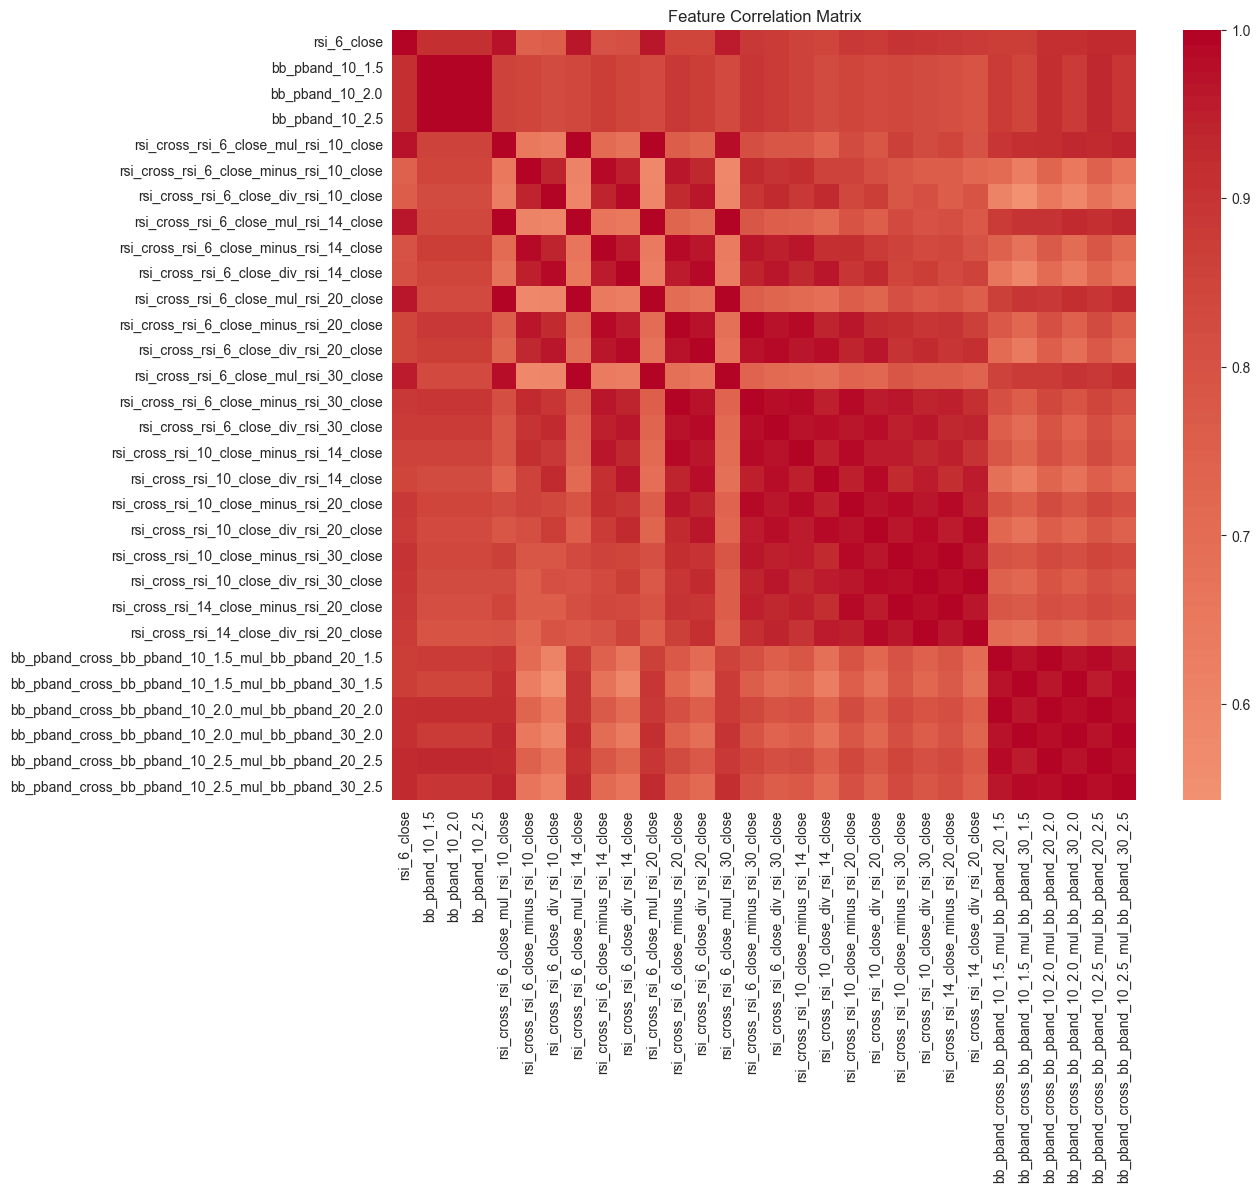

In [13]:
corr = pd.DataFrame(df_filtered).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

#### PCA分析

In [14]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_filtered)
percent = 0.6

cumulative = np.cumsum(pca.explained_variance_ratio_)
n_PCs = np.argmax(cumulative >= percent) + 1

print(f"前 {n_PCs} 个主成分累计解释了 {cumulative[n_PCs - 1]:.2%} 的方差")
feature_names = df_filtered.columns

# 打印所有有重大贡献的主成分
for i in range(n_PCs):
    # 第 i 个主成分的系数
    pc = pca.components_[i]
    
    # 取绝对值最大的特征位置
    top_feature_idx = np.argmax(np.abs(pc))
    top_feature_name = feature_names[top_feature_idx]
    
    print(f"PC{i+1} 的主导因子是: {top_feature_name}（贡献系数: {pc[top_feature_idx]:.4f}）")

前 1 个主成分累计解释了 99.51% 的方差
PC1 的主导因子是: rsi_cross_rsi_6_close_mul_rsi_10_close（贡献系数: 0.5611）
